# Linear and Ringe Regression

In this exercise, we will work with a Residential Building Data Set, which is a set of data that includes construction cost, sale prices, project variables, and economic variables corresponding to real estate single-family residential apartments in Tehran, Iran.

## The goals of the exercise:

  1. To divide data into training and testing set
  2. To do data exploration
  3. To apply Linear and Ridge Regression to the data
    * to evaluate the error apply `mean_absolute_error`.
    * to create new features
    * to standardize/normalize data
    * to select hyperparameters to tune
  4. To apply any a different model for regression (apart from Ringe and Linear)

# 1.  Import libraries & data

In [47]:
# Data handling and processing
import pandas as pd
import numpy as np

# Data visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing data
from sklearn.preprocessing import StandardScaler

# Machine learning algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


# Model fine-tuning and evaluation
from sklearn.model_selection import cross_val_score
from scipy.optimize import minimize_scalar
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from scipy import optimize

# additional modules
import sys
import warnings

In [48]:
# Reading data to pandas df
df = pd.read_excel('Residential-Building-Data-Set.xlsx', header=1)
df.head()

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,...,V-22.4,V-23.4,V-24.4,V-25.4,V-26.4,V-27.4,V-28.4,V-29.4,V-9,V-10
0,81,1,85,1,1,3150.0,920.0,598.5,190,1010.84,...,815.50,1755.00,8002.0,60.74,54.26,2978.26,41407.0,601988.1,2200,410
1,84,1,89,4,1,7600.0,1140.0,3040.0,400,963.81,...,1316.30,8364.78,8393.0,90.95,89.79,11379.37,44835.0,929027.1,5000,1000
2,78,1,81,4,1,4800.0,840.0,480.0,100,689.84,...,765.80,1755.00,4930.0,38.70,32.04,1653.06,37933.0,377828.6,1200,170
3,72,2,73,2,1,685.0,202.0,13.7,20,459.54,...,152.25,1442.31,1456.0,9.73,8.34,686.16,8194.0,122031.7,165,30
4,87,1,90,2,1,3000.0,800.0,1230.0,410,631.91,...,2244.10,9231.76,9286.0,136.60,140.20,9821.00,48260.0,1734973.5,5500,700


Let's also load the name of every variables present in the dataset.

In [49]:
# Loading variable's names
description = pd.read_excel('Residential-Building-Data-Set.xlsx', sheet_name='Descriptions')
display(description.iloc[:-1,[1,2]])

,Variable ID,Descriptions
0,V-1,Project locality defined in terms of zip codes
1,V-2,Total floor area of the building
2,V-3,Lot area
3,V-4,Total preliminary estimated construction cost ...
4,V-5,Preliminary estimated construction cost based ...
5,V-6,Equivalent preliminary estimated construction ...
6,V-7,Duration of construction
7,V-8,Price of the unit at the beginning of the proj...
8,V-9,Actual sales prices (output)
9,V-10,Actual construction costs (output)


# 2. Basic Data Exploration

Let's first separate our targets from features, check if our dataset has null values and what datatypes we are dealing with.

In [50]:
# Separating targets from features
Y1 = df.iloc[:,-2]
Y2 = df.iloc[:,-1]
X = df.iloc[:,:-2]
print(X.shape)

(372, 107)


In [51]:
# Let's check if there are null values in the dataset
print('Null values count:', (df.isnull().sum()).sum())

Null values count: 0


In [52]:
# Checking datatypes
display(df.select_dtypes(include='float').count()) # 94 columns
display(df.select_dtypes(include='int64').count()) # 15 columns

V-2       372
V-3       372
V-4       372
V-6       372
V-11      372
         ... 
V-25.4    372
V-26.4    372
V-27.4    372
V-28.4    372
V-29.4    372
Length: 94, dtype: int64

START YEAR            372
START QUARTER         372
COMPLETION YEAR       372
COMPLETION QUARTER    372
V-1                   372
V-5                   372
V-7                   372
V-8                   372
V-20                  372
V-20.1                372
V-20.2                372
V-20.3                372
V-20.4                372
V-9                   372
V-10                  372
dtype: int64

We can see that all our columns are either int64 or float datatypes. 

# 3. Visual Data Exploration and Feature Engineering

As we saw in the previous section, our model has 107 features, which is quite a lot. With such a big number of features we can easily observe that some features are correlated with each other. In machine learning models, if there are strong correlation between columns (above 0.8 or below -0.8), one of the column is often removed as it doesn't improve the model, do not bring extra information to it. It can improve the speed of the model, decrease dimentionality etc. Let's first check if variables are correlated with each other. The attempt to create a heatmap from all features failed so let's first create a list of columns in each section of the dataframe and first look at the project physical and financial variables. 

In [53]:
# creating a list of coumns in each section for easier access
ProjectPhy_FinancVar = ['V-2', 'V-3', 'V-4', 'V-5', 'V-6', 'V-7', 'V-8']
Lag1 = ['V-11', 'V-12', 'V-13', 'V-14', 'V-15', 'V-16','V-17', 'V-18', 'V-19', 'V-20', 'V-21', 'V-22', 'V-23', 'V-24', 'V-25', 'V-26', 'V-27', 'V-28', 'V-29']
Lag2 = ['V-11.1', 'V-12.1', 'V-13.1', 'V-14.1', 'V-15.1', 'V-16.1','V-17.1', 'V-18.1', 'V-19.1', 'V-20.1', 'V-21.1', 'V-22.1', 'V-23.1', 'V-24.1', 'V-25.1', 'V-26.1', 'V-27.1', 'V-28.1', 'V-29.1']
Lag3 = ['V-11.2', 'V-12.2', 'V-13.2', 'V-14.2', 'V-15.2', 'V-16.2','V-17.2', 'V-18.2', 'V-19.2', 'V-20.2', 'V-21.2', 'V-22.2', 'V-23.2', 'V-24.2', 'V-25.2', 'V-26.2', 'V-27.2', 'V-28.2', 'V-29.2'] 
Lag4 = ['V-11.3', 'V-12.3', 'V-13.3', 'V-14.3', 'V-15.3', 'V-16.3','V-17.3', 'V-18.3', 'V-19.3', 'V-20.3', 'V-21.3', 'V-22.3', 'V-23.3', 'V-24.3', 'V-25.3', 'V-26.3', 'V-27.3', 'V-28.3', 'V-29.3']
Lag5 = ['V-11.4', 'V-12.4', 'V-13.4', 'V-14.4', 'V-15.4', 'V-16.4','V-17.4', 'V-18.4', 'V-19.4', 'V-20.4', 'V-21.4', 'V-22.4', 'V-23.4', 'V-24.4', 'V-25.4', 'V-26.4', 'V-27.4', 'V-28.4', 'V-29.4']

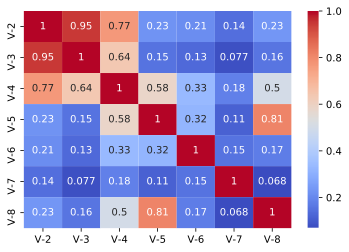

In [54]:
# PROJECT PHYSICAL AND FINANCIAL VARIABLES
corr_matrix_df = X.copy()
corr_matrix_df = corr_matrix_df[ProjectPhy_FinancVar].corr()
corr_matrix=sns.heatmap(corr_matrix_df,annot=True, cmap = "coolwarm") 

_Figure 1: The correlation between project physical and financial variables._

As we see from Figure 1, V-2 (Total floor area) is highly correlated with V-3 (Lot area) and V-5 (Preliminary estimated construction cost based on the prices at the beginning of the project) and V-8 (Price of the unit at the beginning of the project), so we drop one of these features. Now let's look at the economic variables and indices in time lag 1. 

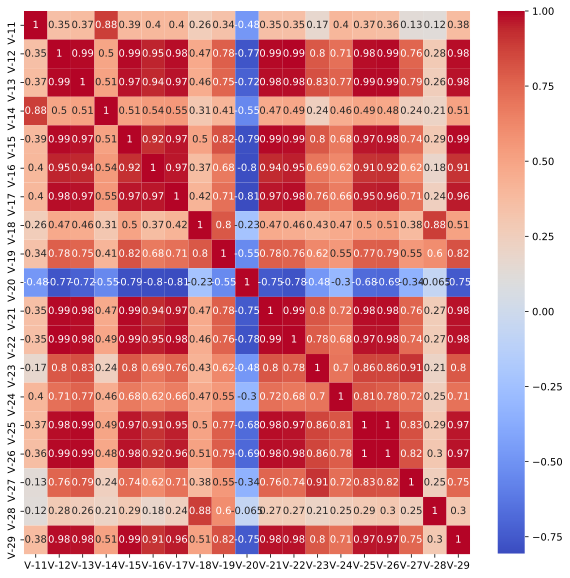

In [9]:
# ECONOMIC VARIABLES AND INDICES IN TIME LAG 1
%config InlineBackend.figure_format = 'svg'
X = X.copy()
corr_matrix_df_1 = X[Lag1].corr()
plt.figure(figsize=(10,10))  
corr_matrix_vis=sns.heatmap(corr_matrix_df_1,annot=True, cmap = "coolwarm") 

_Figure 2: The correlation between economic variables and indices in time lag 1._

As it is seen from Figure 2, there is a strong correlation between features. We will create a mask to remove highly correlated features. But let's also have a look at the lag phase 2 to ensure that it has the same strongly correlated features.

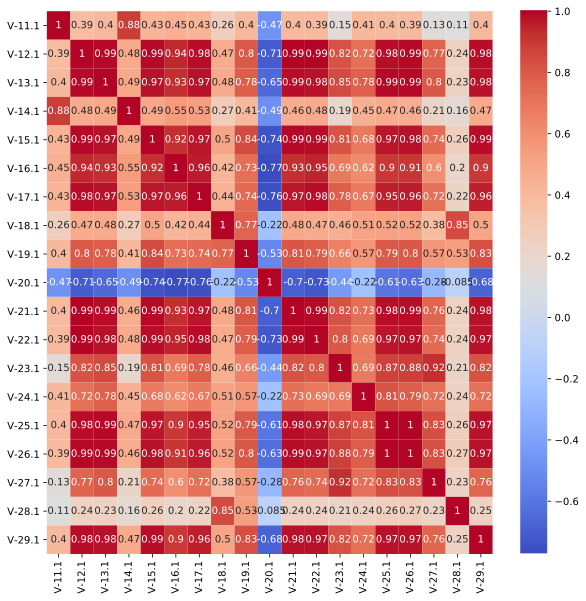

In [10]:
# ECONOMIC VARIABLES AND INDICES IN TIME LAG 2
%config InlineBackend.figure_format = 'svg'
X = X.copy()
corr_matrix_df_2 = X[Lag2].corr()
plt.figure(figsize=(10,10))  
corr_matrix_vis=sns.heatmap(corr_matrix_df_2,annot=True, cmap = "coolwarm") 

_Figure 3: The correlation between economic variables and indices in time lag 2._

In this part, I will create a mask with a value 0.8 and drop all features that have correlation coefficient above this mask.

In [11]:
# creating a dataframe for each section of the original dataframe
X = X.copy()
corr_matrix_df_2 = X[Lag2].corr()
corr_matrix_df_3 = X[Lag3].corr()
corr_matrix_df_4 = X[Lag4].corr()
corr_matrix_df_5 = X[Lag5].corr()

In [12]:
# filtering unnecessary columns
mask = np.triu(np.ones_like(corr_matrix_df, dtype=bool))
mask_1 = np.triu(np.ones_like(corr_matrix_df_1, dtype=bool))
mask_2 = np.triu(np.ones_like(corr_matrix_df_2, dtype=bool))
mask_3 = np.triu(np.ones_like(corr_matrix_df_3, dtype=bool))
mask_4 = np.triu(np.ones_like(corr_matrix_df_4, dtype=bool))
mask_5 = np.triu(np.ones_like(corr_matrix_df_5, dtype=bool))
corr_matrix_df = corr_matrix_df.mask(mask)
corr_matrix_df_1 = corr_matrix_df_1.mask(mask_1)
corr_matrix_df_2 = corr_matrix_df_2.mask(mask_2)
corr_matrix_df_3 = corr_matrix_df_3.mask(mask_3)
corr_matrix_df_4 = corr_matrix_df_4.mask(mask_4)
corr_matrix_df_5 = corr_matrix_df_5.mask(mask_5)
to_drop = [c for c in corr_matrix_df.columns if any(abs(corr_matrix_df[c]) >= 0.8)]
to_drop_1 = [c for c in corr_matrix_df_1.columns if any(abs(corr_matrix_df_1[c]) >= 0.8)]
to_drop_2 = [c for c in corr_matrix_df_2.columns if any(abs(corr_matrix_df_2[c]) >= 0.8)]
to_drop_3 = [c for c in corr_matrix_df_3.columns if any(abs(corr_matrix_df_3[c]) >= 0.8)]
to_drop_4 = [c for c in corr_matrix_df_4.columns if any(abs(corr_matrix_df_4[c]) >= 0.8)]
to_drop_5 = [c for c in corr_matrix_df_5.columns if any(abs(corr_matrix_df_5[c]) >= 0.8)]
drop_all = to_drop + to_drop_1  + to_drop_2 + to_drop_3 + to_drop_4 + to_drop_5

In [13]:
# dropping unnecessary columns
X = X.drop(drop_all, axis=1)

In [14]:
print(X.shape)
X.head()

(372, 36)


,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-3,V-4,V-6,V-7,V-8,...,V-19.3,V-20.3,V-27.3,V-28.3,V-29.3,V-14.4,V-20.4,V-27.4,V-28.4,V-29.4
0,81,1,85,1,1,920.0,598.5,1010.84,16,1200,...,3114.15,15,3387.72,10646.75,606524.2,5.97,15,2978.26,41407.0,601988.1
1,84,1,89,4,1,1140.0,3040.0,963.81,23,2900,...,4396.08,15,12063.50,11491.50,954628.6,3.25,15,11379.37,44835.0,929027.1
2,78,1,81,4,1,840.0,480.0,689.84,15,630,...,1622.28,15,1601.79,9766.50,403875.0,1.55,15,1653.06,37933.0,377828.6
3,72,2,73,2,1,202.0,13.7,459.54,4,140,...,305.20,12,590.64,16388.00,121857.2,3.00,12,686.16,8194.0,122031.7
4,87,1,90,2,1,800.0,1230.0,631.91,13,5000,...,17361.20,11,9291.00,12393.00,1732937.5,4.09,14,9821.00,48260.0,1734973.5


Now we reduced the number of features from 107 to 36. Good job, but let's keep exploring as the number of dimensions is still quite high. Let's now check if there are any relationship in different time lags of those variable, which we kept.

In [15]:
# checking remaining columns
print(X.columns)

Index(['START YEAR', 'START QUARTER', 'COMPLETION YEAR', 'COMPLETION QUARTER',
       'V-1', 'V-3', 'V-4', 'V-6', 'V-7', 'V-8', 'V-14', 'V-20', 'V-27',
       'V-28', 'V-29', 'V-14.1', 'V-20.1', 'V-27.1', 'V-28.1', 'V-29.1',
       'V-14.2', 'V-20.2', 'V-27.2', 'V-28.2', 'V-29.2', 'V-14.3', 'V-19.3',
       'V-20.3', 'V-27.3', 'V-28.3', 'V-29.3', 'V-14.4', 'V-20.4', 'V-27.4',
       'V-28.4', 'V-29.4'],
      dtype='object')


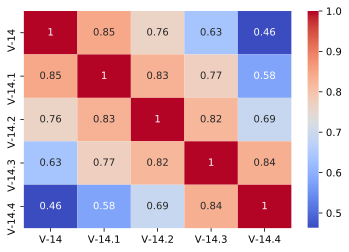

In [16]:
# V-14 Total floor areas of building permits issued by the city/municipality
X = X.copy()
corr_matrix=sns.heatmap(X[['V-14', 'V-14.1', 'V-14.2', 'V-14.3', 'V-14.4']].corr(),annot=True, cmap = "coolwarm") 

_Figure 4: The correlation between total floor areas of building permits issued by the city/municipality in different lag phases._

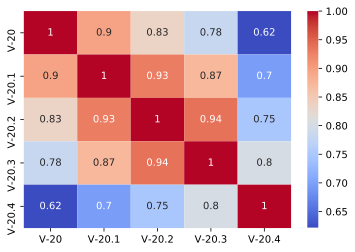

In [17]:
# V-20 The interest rate for loan in a time resolution
X = X.copy()
corr_matrix=sns.heatmap(X[['V-20', 'V-20.1', 'V-20.2', 'V-20.3', 'V-20.4']].corr(),annot=True, cmap = "coolwarm") 

_Figure 5: The correlation between The interest rate for loan in a time resolution in different lag phases._

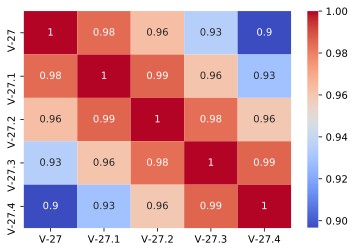

In [18]:
# V-27 Stock market index
X = X.copy()
corr_matrix=sns.heatmap(X[['V-27', 'V-27.1', 'V-27.2', 'V-27.3', 'V-27.4']].corr(),annot=True, cmap = "coolwarm")

_Figure 6: The correlation between stock market index in different lag phases._

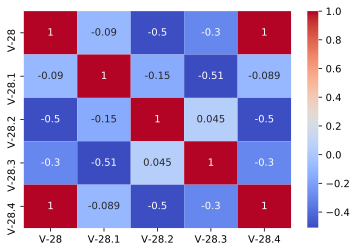

In [19]:
# V-28 Population of the city
X = X.copy()
corr_matrix=sns.heatmap(X[['V-28', 'V-28.1', 'V-28.2', 'V-28.3', 'V-28.4']].corr(),annot=True, cmap = "coolwarm")

_Figure 7: The correlation between population of the city in different lag phases._

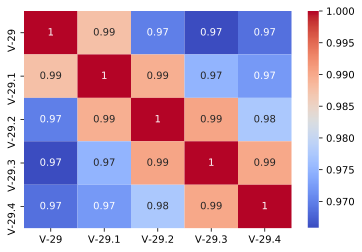

In [20]:
# V-29 Gold price per ounce
X = X.copy()
corr_matrix=sns.heatmap(X[['V-29', 'V-29.1', 'V-29.2', 'V-29.3', 'V-29.4']].corr(),annot=True, cmap = "coolwarm")

_Figure 8: The correlation between gold price per ounce in different lag phases._

As it is seen from upper charts, there is an extremely strong correlation between all variables in different lag phases of V-27 (Stock market index) and V-29 (Gold price per ounce). In this case, we will drop these variable from last four lag phases keeping just the one for further analysis. We will also drop V-14.1 as it correlates with V-14. The same pattern was observed for columns V-20,V-20.1 and V-20.2, V-28 and V-28.4. 

In [21]:
# dropping unnecessary columns
X = X.drop(['V-14.1', 'V-20.1', 'V-20.2', 'V-28.4',
            'V-27.1', 'V-27.2', 'V-27.3', 'V-27.4',
            'V-29.1', 'V-29.2', 'V-29.3', 'V-29.4'], axis=1) 

In [22]:
# checking the number features
print(X.shape)

(372, 24)


So now we decreased the number of features to 24, which is good but let's still explore. Let's check if there is correlation between all remaining columns.

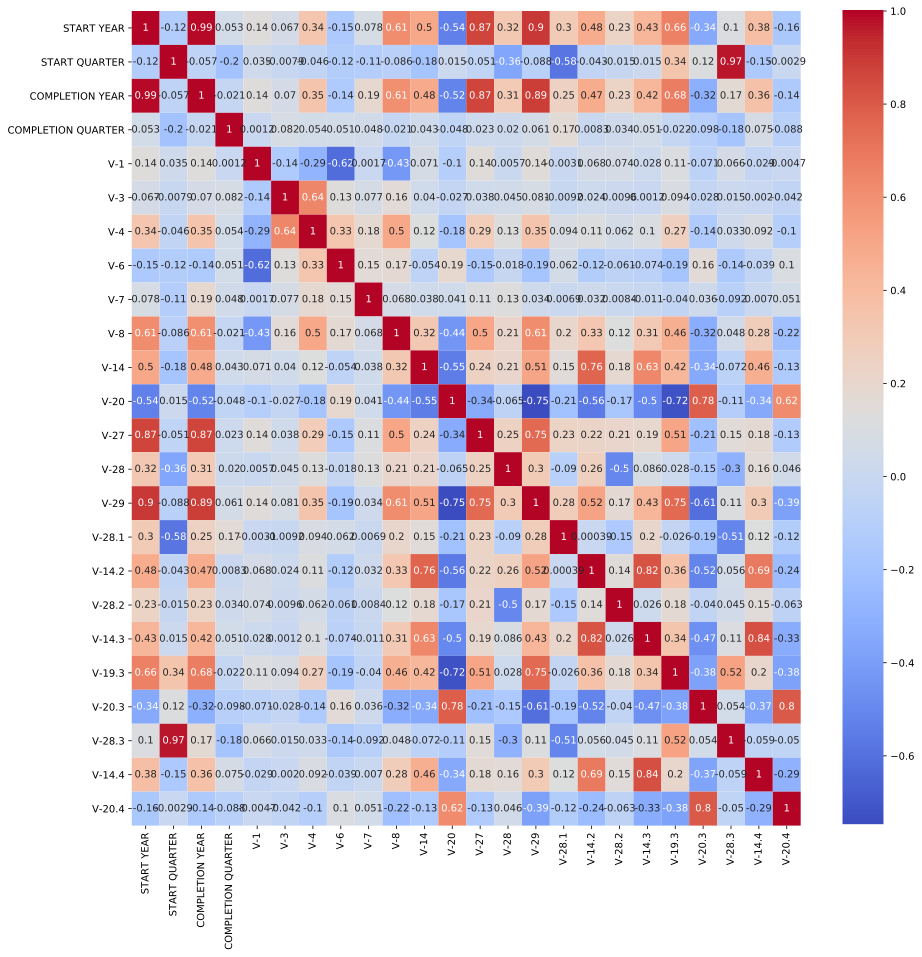

In [23]:
# heatmap of the remaining columns
X = X.copy()
%config InlineBackend.figure_format = 'svg'
cols = X.columns.to_list()
corr_matrix = X[cols].corr()
plt.figure(figsize=(15,15))   
corr_matrix_vis=sns.heatmap(corr_matrix, annot=True, cmap = "coolwarm") 

_Figure 9: The correlation between between variables after dropping highly correlated features._

As we can see from Figure 9, there are still some highly correlated variables. Let's then apply a mask to remove them.

In [24]:
# masking highly correlated values
mask_corr = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask_corr)
to_drop_corr = [c for c in corr_matrix.columns if any(abs(corr_matrix[c]) >= 0.8)]
X = X.drop(to_drop_corr, axis=1)

In [25]:
# checking the number of features
print(X.shape)

(372, 18)


So now we reduced the number of features to 18. That's good enough to build a model, however there are some variables in the dataframe, which require encoding to dummies variables. Moreover, the completion quarter column should be first grouped before encoding to dummies variables.

In [26]:
# creating a new category Zip Code
def zip_code(row):
  if row['V-1'] >= 1.0 and row['V-1'] <= 5.0:
    return '1-5'
  if row['V-1'] > 5.0 and row['V-1'] <= 10.0:
    return '6-10'
  if row['V-1'] > 10.0 and row['V-1'] <= 15.0:
    return '11-15'
  else:
    return '16-20'

X['Zip Code'] = X.apply(zip_code, axis=1)

In [27]:
# changing datatype and encoding categorical variables
X['COMPLETION QUARTER'] = X['COMPLETION QUARTER'].astype('object')
X['Zip Code'] = X['Zip Code'].astype('object')
X = X.drop('V-1', axis=1)
X = pd.get_dummies(X)
X.head()

,V-3,V-4,V-6,V-7,V-8,V-14,V-20,V-27,V-28,V-29,...,V-14.4,V-20.4,COMPLETION QUARTER_1,COMPLETION QUARTER_2,COMPLETION QUARTER_3,COMPLETION QUARTER_4,Zip Code_1-5,Zip Code_11-15,Zip Code_16-20,Zip Code_6-10
0,920.0,598.5,1010.84,16,1200,6.11,15,3758.77,42587.00,628132.9,...,5.97,15,1,0,0,0,1,0,0,0
1,1140.0,3040.0,963.81,23,2900,3.15,15,12113.01,45966.00,1188995.8,...,3.25,15,0,0,0,1,1,0,0,0
2,840.0,480.0,689.84,15,630,1.74,15,1537.96,39066.00,524764.8,...,1.55,15,0,0,0,1,1,0,0,0
3,202.0,13.7,459.54,4,140,1.24,12,392.96,8435.75,141542.6,...,3.00,12,0,1,0,0,1,0,0,0
4,800.0,1230.0,631.91,13,5000,6.46,11,10082.00,49572.00,2318397.0,...,4.09,14,0,1,0,0,1,0,0,0


Let's now standardize our data.

In [28]:
# data standardization
scaler = StandardScaler()
Xstd = scaler.fit_transform(X)
X_scaled = pd.DataFrame(Xstd, index = X.index, columns = X.columns)
display(X_scaled.head())

,V-3,V-4,V-6,V-7,V-8,V-14,V-20,V-27,V-28,V-29,...,V-14.4,V-20.4,COMPLETION QUARTER_1,COMPLETION QUARTER_2,COMPLETION QUARTER_3,COMPLETION QUARTER_4,Zip Code_1-5,Zip Code_11-15,Zip Code_16-20,Zip Code_6-10
0,1.009130,0.480815,1.661305,4.649179,0.112502,1.551777,0.610242,-0.671468,1.031628,-0.653984,...,2.157212,0.512216,1.865992,-0.581489,-0.560792,-0.631266,1.302172,-0.442879,-0.610486,-0.489898
1,1.458644,4.819050,1.490122,7.992582,1.821926,-0.282096,0.610242,1.299459,1.275565,0.233231,...,0.069012,0.512216,-0.535908,-0.581489,-0.560792,1.584119,1.302172,-0.442879,-0.610486,-0.489898
2,0.845670,0.270255,0.492910,4.171550,-0.460658,-1.155664,0.610242,-1.195400,0.777440,-0.817499,...,-1.236112,0.512216,-0.535908,-0.581489,-0.560792,1.584119,1.302172,-0.442879,-0.610486,-0.489898
3,-0.457921,-0.558301,-0.345349,-1.082369,-0.953374,-1.465440,-1.358052,-1.465527,-1.433818,-1.423708,...,-0.122918,-2.303713,-0.535908,1.719723,-0.560792,-0.631266,1.302172,-0.442879,-0.610486,-0.489898
4,0.763941,1.602910,0.282053,3.216292,3.933568,1.768620,-2.014150,0.820304,1.535889,2.019801,...,0.713897,-0.426427,-0.535908,1.719723,-0.560792,-0.631266,1.302172,-0.442879,-0.610486,-0.489898


In [29]:
# the final shape of the data before modeling
print(X_scaled.shape)

(372, 24)


As we can see the encoding increased the dimensionality of our data, but it is ok and we can start building our models now.

# 5. Data Modeling

Before we start building our models, we will create a function create_model.

In [30]:
# function for testing different models
def create_model(name, model, X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state=333)
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    results = cross_val_score(model, X,Y,cv=kfold, scoring='neg_mean_absolute_error')
    return print(f'Model {name} with MAE: ', results.mean())

Let's create a dictionary with names of scikit-learn functions, which we will use in our regression model.

In [31]:
# dictionary of scikit-learn functions
models = {'LinearRegression' : LinearRegression(),
          'Lasso' : Lasso(),
          'Ridge' : Ridge(),
          'ElasticNet' :ElasticNet()}

We need to predict two columns V-9 and V-10, so let's first use our model for the prediction of V-9 (Actual sales prices) column with default hyperparameters.

In [36]:
# predicting V-9 column
for key, val in models.items():
    create_model(key, val, X, Y1)

Model LinearRegression with MAE:  -139.01272036647615
Model Lasso with MAE:  -137.455281761226
Model Ridge with MAE:  -138.73421080936606
Model ElasticNet with MAE:  -130.24142072627814


Let's use our create_model function to predict V-10 (Actual construction costs) column  with default parameters.

In [37]:
# predicting V-10 column
for key, val in models.items():
    create_model(key, val, X, Y2)

Model LinearRegression with MAE:  -36.48566342254939
Model Lasso with MAE:  -35.817814464782785
Model Ridge with MAE:  -36.43912214648223
Model ElasticNet with MAE:  -35.36988351478624


Let's now try to find the optimal alpha hyperparameter for our Lasso, Ridge and ElasticNet models. To do that, we will create get_model_with_alpha function.

In [38]:
# hyperparameter tuning function
def get_model_with_alpha(Model, X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state=333)
    def optimal_alpha(alpha):
        return -np.mean(model_selection.cross_val_score(Model(alpha), X, Y, cv=5, scoring='neg_mean_squared_error'))

    alphas = range(20)
    alphas_res = [np.sqrt(optimal_alpha(alpha)) for alpha in alphas]
    opt_alpha = optimize.minimize_scalar(optimal_alpha, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
    print(f'Optimal alpha {Model}', opt_alpha.x)
    clf = Model(alpha = opt_alpha.x)
    clf.fit(X_train,y_train)
    Yth = clf.predict(X_test)
    print('MAE:', mean_absolute_error(Yth, np.array(y_test)))

We will first apply this function for prediction of V-9 column, then V-10 column. 

In [41]:
# hyperparameter tuning for V-9 column
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
for i in [Lasso, Ridge, ElasticNet]:
    get_model_with_alpha(i, X, Y1)

Optimal alpha <class 'sklearn.linear_model._coordinate_descent.Lasso'> 2.048834564196615
MAE: 131.55571755161557
Optimal alpha <class 'sklearn.linear_model._ridge.Ridge'> 14.636963659825744
MAE: 130.42989040547573
Optimal alpha <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> 0.10021494245089224
MAE: 130.4201840365875


In [42]:
# hyperparameter tuning for V-10 column
for i in [Lasso, Ridge, ElasticNet]:
    get_model_with_alpha(i, X, Y2)

Optimal alpha <class 'sklearn.linear_model._coordinate_descent.Lasso'> 25.064451248657303
MAE: 28.81203039333094
Optimal alpha <class 'sklearn.linear_model._ridge.Ridge'> 8.80743786303038
MAE: 28.940087375643724
Optimal alpha <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> 0.10021494245089224
MAE: 28.60999761639443


# 6. Conclusion

As it is seen the lowest mean absolute error was observed for ElasticNet model. As this model showed the best performance let's visualize how our model fits the data with an optimal alpha hyperparameter. 

[-2.72517077e-02  4.40929991e-02 -5.29011836e-02  4.54373652e+01
  1.16290429e+00  3.18529016e+01 -2.54888712e+01  1.90565052e-02
 -7.67133724e-03 -8.33226118e-05 -7.46949911e-03 -7.20572142e-03
  7.48124905e-03 -1.18330417e-02 -4.29373217e+01  1.25091703e+02
 -3.18159430e+01  9.99427309e+00  1.70861756e+00  1.81130524e+01
  3.57297600e+01 -1.99754500e+01 -3.62988616e+01  2.05445515e+01]


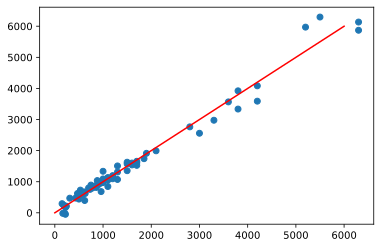

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,Y1, test_size=0.20, random_state=333)
final_model = ElasticNet(alpha=0.10)
final_model.fit(X_train,y_train)
print(final_model.coef_)
Yth = final_model.predict(X_test)
plt.scatter(y_test, Yth)
plt.plot([0,6000], [0,6000], 'r')

_Figure 10: ElasticNet regression model applied to Residential Building Data Set for prediction of actual sales price._

[-2.94226490e-02  5.13075191e-02  1.51241384e-01  1.26932932e+01
  3.96504045e-02 -4.63964402e+00 -6.31740178e+00  2.71163230e-03
  3.18873235e-03  7.33283605e-05  2.94645357e-03  2.80758489e-03
  6.84659580e-04  2.47352933e-03 -1.12585665e+00 -4.27090123e+00
  3.15134799e-01 -0.00000000e+00 -8.47310336e+00  8.09666731e+00
  1.11833417e+01  9.84691031e-01 -1.81692148e+01  4.00118203e+00]


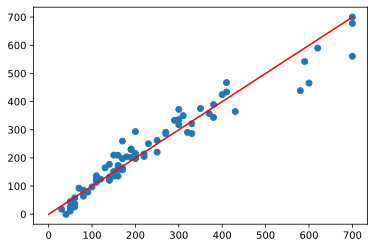

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,Y2, test_size=0.20, random_state=333)
final_model = ElasticNet(alpha=0.10)
final_model.fit(X_train,y_train)
print(final_model.coef_)
Yth = final_model.predict(X_test)
plt.scatter(y_test, Yth)
plt.plot([0,700], [0,700], 'r')

_Figure 11: ElasticNet regression model applied to Residential Building Data Set for prediction of actual construction cost._